## **ABCDEats Company - Customer Segmentation**

## **Group Members:**

* **Guilherme Goudinho**- 20211552
* **Maria Inês Assunção**- 20211605
* **Osmáiny Raimundo**- e20191506
* **Vinincius Lallo**- 20211682

<a id = "toc"></a>
## Table of Contents

1. [Imports](#Imports)
    
2. [Data Preprocessing](#Imports) <br>


### **1. Imports** <a id="Imports" class="anchor"></a>
[Back to ToC](#toc)<br>

In [2]:
#Importing the necessary libraries for our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import ceil
from PIL import Image
from IPython.display import display
from matplotlib.animation import Animation #For the sequential HR graphs
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation #For the sequential HR graphs
from scipy.stats import chi2_contingency
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from ydata_profiling import ProfileReport
%config InlineBackend.figure_format = 'retina' # for better resolution plots
sns.set()
pd.set_option('display.max_columns', None) # to see all the columns

In [3]:
# Auxiliary Function to Calculate bins for histograms based on Sturges' rule
def number_bins_sturges(data):
    '''
    Calculates the number of bins based on the number of data points, using Sturges' rule
    Sturges' rule: k = log2(n) + 1

    Requires: The dataset for which the number of bins is to be calculated.
    Ensures: 
        - The returned value is a positive integer representing the number of bins.
        - The number of bins increases logarithmically as the dataset size increases.
    '''
    
    n = len(data)
    bins = np.ceil(np.log2(n) + 1) # np.log2 computes the base-2 logarithm of n, and np.ceil rounds the result up to the next whole number.
    return int(bins)

#Defining the colors for our graphs
colors = {
    "R": "#F5979D", #light red
    "BL": "#0a9ea3", #cyan blue
    "BR": "#4F323D", #brown
    "B": "#9cc5d9",  #light blue
    "G": "#099c52",  #spring green
    "Y": "#d69231",   #Yellow
    "M": "#960b50",   # some kind of pink
    "P": "#6947ad" ,   # Purple
    "PR": "#ad474c"  #Weird red
}

def show_missing(data):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []
    for item in data.columns:
        variables.append(item)
        dtypes.append(data[item].dtype)
        count.append(len(data[item]))
        unique.append(len(data[item].unique()))
        missing.append(data[item].isna().sum())
    output = pd.DataFrame({
    'variable': variables, 
    'dtype': dtypes,
    'count': count,
    'unique': unique,
    'missing': missing, 
    })
    return output

### **2. Loading our Dataset**

In [4]:
food_df=pd.read_csv("food_df_dataset.csv") # Importing our dataset into a variable "food_df" with imputed missing values

__**Setting our Index Column**__

In [5]:
food_df = food_df.set_index('customer_id')

In [6]:
food_df['customer_region'].dtype

dtype('int64')

> This is wrong, probably as a consequence of the data exporting, so we need to turn <code>customer_region</code> back into 'object'.

In [7]:
food_df['customer_region'] = food_df['customer_region'].astype('object') # fixed

> We imputed our <b>Missing Values</b> in the previous notebook and exported the dataset with these treated.
> - <code>customer_age</code>: Imputed with the mean. (After conducting analysis)
> - <code>first_order</code>: Imputed with '0' as these corresponded to customers whose first_order was on the same day as last_order (day 0).
> - <code>HR_0</code>: Imputed with the discrepancy between total_order by DOW and by HR.

In [8]:
columns_with_missing = food_df.isna().sum()[food_df.isna().sum() > 0].count()
print(f"There are {columns_with_missing} columns with more than 0 missing values.")

There are 0 columns with more than 0 missing values.


In [9]:
food_df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'HR_0', 'HR_1', 'HR_2',
       'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9', 'HR_10',
       'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17', 'HR_18',
       'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'total_orders',
       'midday_orders', 'evening_orders', 'late_night_orders', 'Weekend',
       'Weekday', 'Western_Cuisine', 'Asian_Cuisine', 'Desserts_Beverages',
       'total_spent'],
      dtype='object')

### **3. Separating Our Data**

> We will drop the following columns as they were previously engineered to be represented by aggregations, described in our EDA and initial preprocessing notebook (part 1).

In [10]:
columns_to_drop = ['DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 
                   'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 
                   'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 
                   'HR_15', 'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 
                   'HR_22', 'HR_23',
                   'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe', 
                   'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 
                   'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes', 
                   'CUI_Thai']
food_df = food_df.drop(columns=columns_to_drop)
show_missing(food_df)

,variable,dtype,count,unique,missing
0,customer_region,object,31737,3,0
1,customer_age,int64,31737,66,0
2,vendor_count,int64,31737,36,0
3,product_count,int64,31737,92,0
4,is_chain,int64,31737,60,0
5,first_order,int64,31737,91,0
6,last_order,int64,31737,91,0
7,last_promo,object,31737,4,0
8,payment_method,object,31737,3,0
9,CUI_Healthy,float64,31737,1285,0


> After conducting our analysis on the box plots for each of our numerical variables, we concluded that our one-time customers were probably creating a bias in our data. <br>
> For this reason, we decided to separate this type of customer and perform a separate analysis. The rest of our data will represent the behavior of the customers we are trying to segment.<br>
> We believe this will highly influence our outlier percentages, lowering them and allow us to retain as much information as possible. <br>

> This notebook will address the <b>One-Time Customers</b>.

In [11]:
one_time_customers_df = food_df[food_df['total_orders'] == 1]
food_df = food_df[food_df['total_orders'] > 1]
print(f"One-time customers: {one_time_customers_df.shape[0]} records")
print(f"Remaining customers: {food_df.shape[0]} records")

One-time customers: 6908 records
Remaining customers: 24829 records


> We identified <b>6908</b> records where customers only made 1 purchase. <br>
> These represent roughly 22% of our data. <br>

### **One-Time Customers**

In [12]:
show_missing(one_time_customers_df)

,variable,dtype,count,unique,missing
0,customer_region,object,6908,3,0
1,customer_age,int64,6908,58,0
2,vendor_count,int64,6908,1,0
3,product_count,int64,6908,6,0
4,is_chain,int64,6908,2,0
5,first_order,int64,6908,91,0
6,last_order,int64,6908,91,0
7,last_promo,object,6908,4,0
8,payment_method,object,6908,3,0
9,CUI_Healthy,float64,6908,141,0


In [13]:
numerical_columns = one_time_customers_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = one_time_customers_df.select_dtypes(include=['object', 'O']).columns

__**Data Statistics for One-Time Customers**__

In [14]:
one_time_customers_df.describe().round(2)

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_Healthy,CUI_OTHER,CUI_Street Food / Snacks,total_orders,midday_orders,evening_orders,late_night_orders,Weekend,Weekday,Western_Cuisine,Asian_Cuisine,Desserts_Beverages,total_spent
count,6908.00,6908.0,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.0,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00,6908.00
mean,27.43,1.0,1.38,0.60,46.12,46.17,0.24,0.90,2.32,1.0,0.40,0.42,0.18,0.54,0.46,2.81,6.45,1.45,14.18
std,7.11,0.0,0.62,0.49,26.49,26.51,2.12,3.66,9.07,0.0,0.49,0.49,0.38,0.50,0.50,6.05,10.03,5.44,11.12
min,15.00,1.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.37
25%,22.00,1.0,1.00,0.00,23.00,23.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.09
50%,26.00,1.0,1.00,1.00,47.00,47.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,11.75
75%,31.00,1.0,2.00,1.00,69.00,69.00,0.00,0.00,0.00,1.0,1.00,1.00,0.00,1.00,1.00,1.99,11.45,0.00,18.69
max,77.00,1.0,6.00,1.00,90.00,90.00,43.33,78.94,104.32,1.0,1.00,1.00,1.00,1.00,1.00,55.37,91.16,73.02,104.32


> - The average <code>customer_age</code> is still 27y.
> - On average, customers who only made one order, got about 1.38 products.
> - 75% of the one-time customers, did it within the first 2 months and some spare time.
> - Amounts spent by <code>CUI Aggregations</code> is relatively low.
> - One-time customers spent the most on <code>Asian_Cuisine</code> followed by <code>Western_Cuisine</code>, with 6.45€ and 2.81€ respectively.
> - There are more orders during the midday or the evening. Also weekends have more orders.
> - On average, a one-time customer spends 14.18€ ordering out. The max for <code>total_spent</code> is 104.32€ which is surprising for 1 order.

__**Checking Box Plots**__

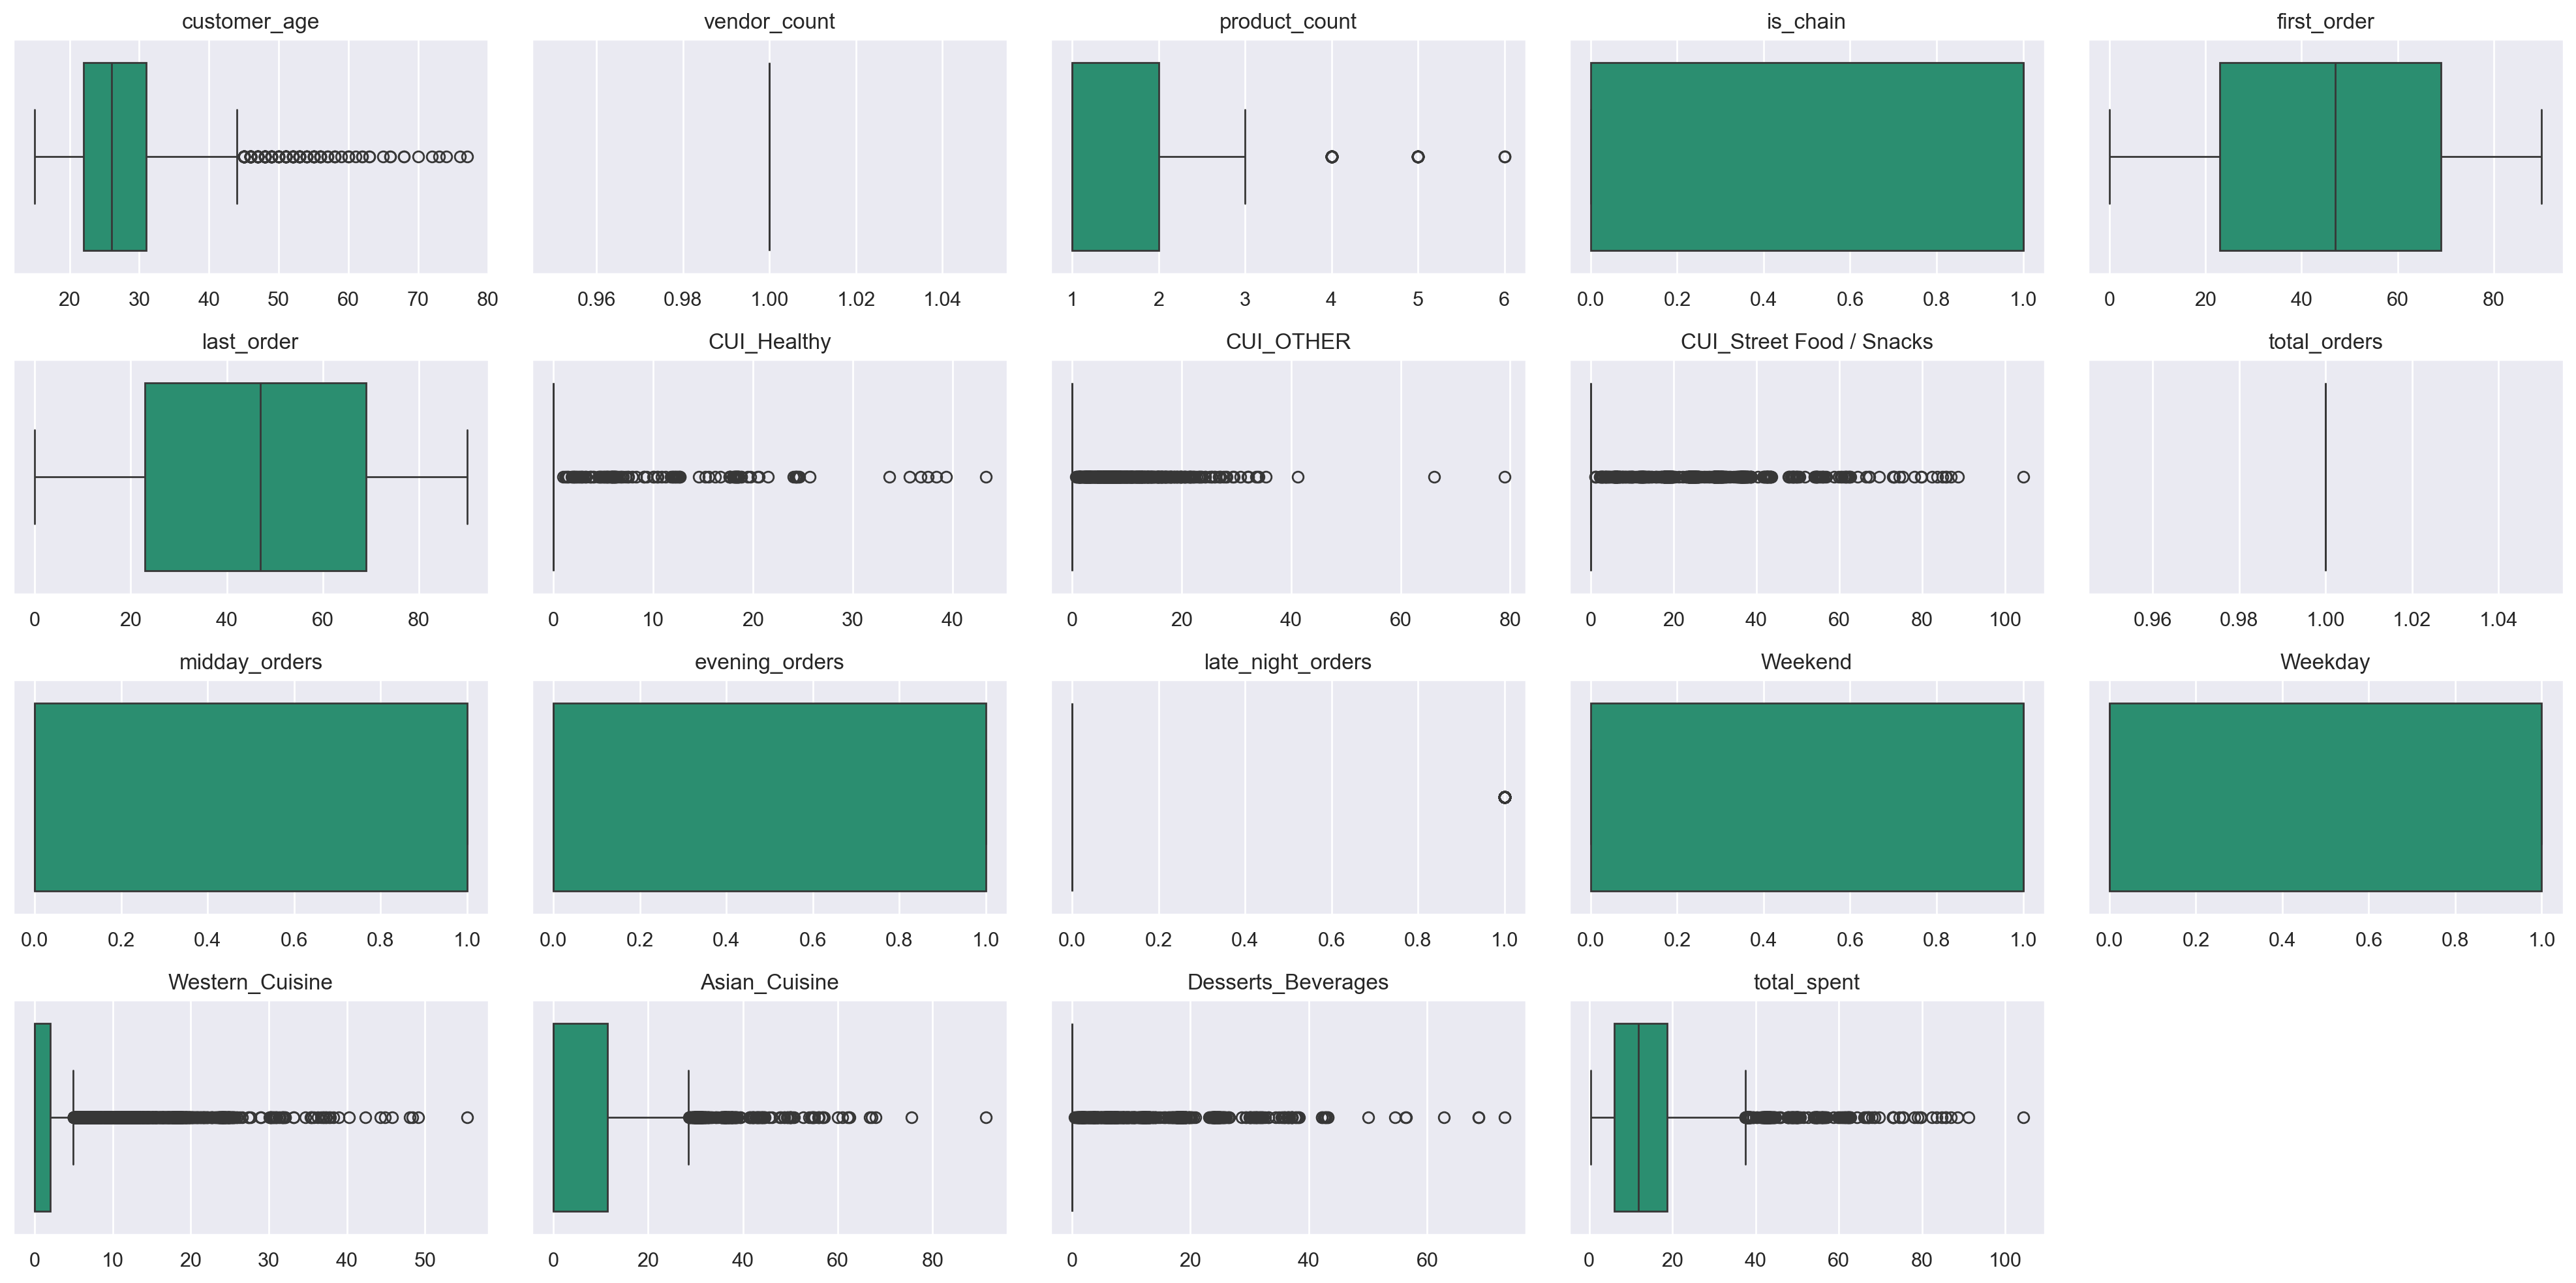

In [15]:
def plot_horizontal_boxplots(data, columns):
    """
    Generate horizontal box plots for each variable in the provided list of columns.
    The plots are arranged in 2 rows and 9 columns.
    
    Parameters:
    - data: DataFrame containing the data.
    - columns: List of column names to plot.
    """
    ncols = 5  # Number of plots per row
    nrows = 4  # Fixed to 2 rows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for idx, col in enumerate(columns):
        # Calculate IQR
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
                
        # Plot horizontal boxplot
        sns.boxplot(data=data, x=col, ax=axes[idx], palette="Dark2", orient="h")
        axes[idx].set_title(f"{col}")
        axes[idx].set_xlabel("")
    
    # Hide unused subplots if any
    for ax in axes[len(columns):]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage example
plot_horizontal_boxplots(data=one_time_customers_df, columns=numerical_columns)

In [17]:
outlier_percentages = {}

# We know that low outliers are below Q 1 − 1.5 ⋅ IQR ‍ and high outliers are above Q 3 + 1.5 ⋅ IQR 
for column in numerical_columns:
        #Defining Q1 and Q3 to then find IQR 
        Q1 = one_time_customers_df[column].quantile(0.25)
        Q3 = one_time_customers_df[column].quantile(0.75)
        IQR = Q3 - Q1
        #Getting the outliers below the first quantile and above the second quantile
        outliers = one_time_customers_df[(one_time_customers_df[column] < (Q1 - 1.5 * IQR)) | (one_time_customers_df[column] > (Q3 + 1.5 * IQR))]
        #Getting the percentage of the outliers
        percentage_outliers = (len(outliers) / len(one_time_customers_df)) * 100
        outlier_percentages[column] = percentage_outliers

print("Percentage of outliers per column using IQR:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: \033[1;35m{percentage:.2f}%\033[0m")


Percentage of outliers per column using IQR:
customer_age: 2.88%
vendor_count: 0.00%
product_count: 1.06%
is_chain: 0.00%
first_order: 0.00%
last_order: 0.00%
CUI_Healthy: 2.08%
CUI_OTHER: 8.80%
CUI_Street Food / Snacks: 8.58%
total_orders: 0.00%
midday_orders: 0.00%
evening_orders: 0.00%
late_night_orders: 17.96%
Weekend: 0.00%
Weekday: 0.00%
Western_Cuisine: 20.56%
Asian_Cuisine: 4.23%
Desserts_Beverages: 10.86%
total_spent: 3.46%


> - 1 <br>
> - 2<br>
> - 3
> - 4